In [135]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


In [136]:
DATASET_PATH = './data/data_Animal'

# Image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    rotation_range=30,  
    width_shift_range=0.2, 
    height_shift_range=0.2,  
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest',  
    validation_split=0.2 
)

# Data generator for the validation set 
validation_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    validation_split=0.2  
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,  
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    subset='training'  
)

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    subset='validation'  
)

Found 5966 images belonging to 8 classes.
Found 1489 images belonging to 8 classes.


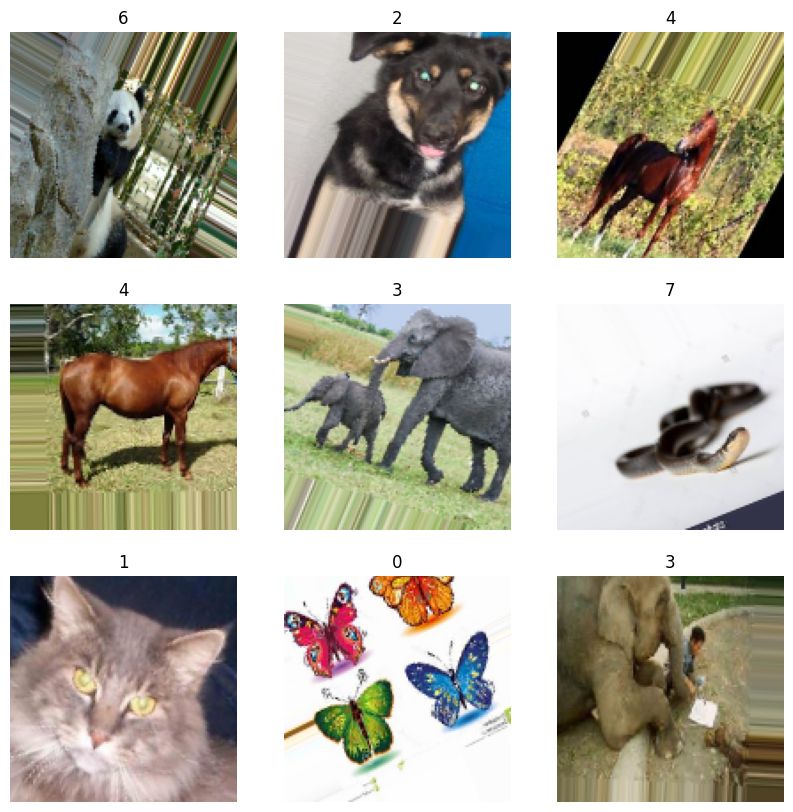

In [137]:
# Display a batch of images
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype(np.uint8))  # Convert back to uint8 for proper display
    plt.title(np.argmax(labels[i]))
    plt.axis('off')
plt.show()


In [148]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    #3 convolutional layers 
    #to convert the 2D feature into a 1D vector.
    #for multi-class classification.
    # to prevent overfitting.

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])



In [ ]:
# Calculates the class weights using compute_class_weight to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 1.1015509601181683, 1: 0.9321875, 2: 0.9321875, 3: 0.958547557840617, 4: 1.0050539083557952, 5: 0.9956608811748998, 6: 1.2028225806451613, 7: 0.9321875}


In [140]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [141]:

# Train the model 
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict  
)

Epoch 1/20
186/186 [==============================] - 234s 1s/step - loss: 3.1391 - accuracy: 0.2260 - val_loss: 5.1078 - val_accuracy: 0.1501
Epoch 2/20
186/186 [==============================] - 216s 1s/step - loss: 1.9501 - accuracy: 0.2442 - val_loss: 2.0048 - val_accuracy: 0.2466
Epoch 3/20
186/186 [==============================] - 183s 986ms/step - loss: 1.9350 - accuracy: 0.2651 - val_loss: 1.8049 - val_accuracy: 0.3567
Epoch 4/20
186/186 [==============================] - 185s 994ms/step - loss: 1.8030 - accuracy: 0.3175 - val_loss: 1.7025 - val_accuracy: 0.3743
Epoch 5/20
186/186 [==============================] - 193s 1s/step - loss: 1.7343 - accuracy: 0.3386 - val_loss: 1.9234 - val_accuracy: 0.2772
Epoch 6/20
186/186 [==============================] - 167s 896ms/step - loss: 1.6936 - accuracy: 0.3599 - val_loss: 1.5203 - val_accuracy: 0.4307
Epoch 7/20
186/186 [==============================] - 164s 882ms/step - loss: 1.6475 - accuracy: 0.3795 - val_loss: 4.2793 - val_accu

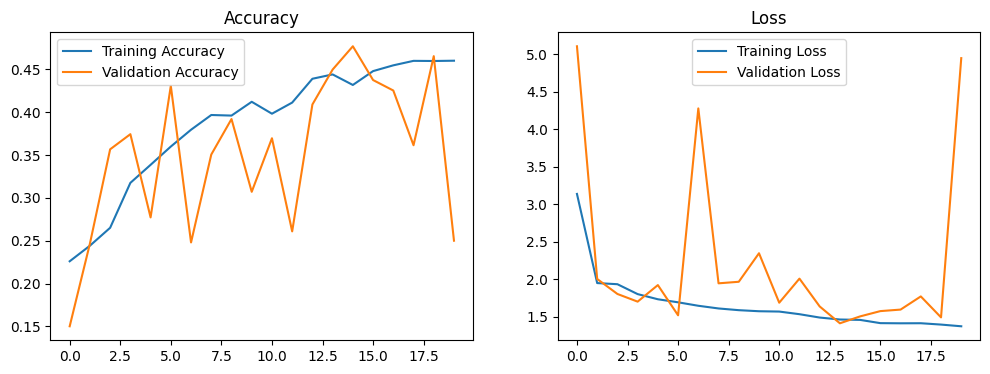

In [142]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [143]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

47/47 [==============================] - 31s 660ms/step - loss: 4.9534 - accuracy: 0.2505
Validation Loss: 4.953378677368164
Validation Accuracy: 0.25050368905067444


In [144]:

y_pred = np.argmax(model.predict(validation_generator), axis=1)
y_true = validation_generator.classes

# Confusion matrix and classification report generated to assess the performance for each class
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


47/47 [==============================] - 28s 581ms/step
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.11      0.64      0.19       169
        cats       0.14      0.09      0.11       200
        dogs       0.15      0.01      0.03       200
    elephant       0.33      0.02      0.03       194
       horse       0.12      0.11      0.12       185
      monkey       0.11      0.05      0.07       187
       panda       0.11      0.04      0.06       154
      snakes       0.21      0.05      0.08       200

    accuracy                           0.12      1489
   macro avg       0.16      0.13      0.09      1489
weighted avg       0.16      0.12      0.08      1489

Confusion Matrix:
[[108  12   2   1  20  14   4   8]
 [134  18   4   0  27   9   4   4]
 [138  15   3   0  23  11   5   5]
 [118  15   3   3  29  13   9   4]
 [116  20   1   0  21  12   8   7]
 [121  18   1   1  20  10   8   8]
 [104  10   1   1  16  14   6   2]
 [119  

In [145]:
model.save("animal_species_classifier.h5")


C:\Users\NITHAN ANTO\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [146]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model = load_model('animal_species_classifier.h5')



In [152]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Preprocess the input image
img_path = './images/elephant.jpeg'  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img) / 255.0  
img_array = np.expand_dims(img_array, axis=0) 

# Predict the class of the test image
predictions = model.predict(img_array)
predicted_index = np.argmax(predictions)  


# Check prediction probabilities
print(f"Prediction Probabilities: {predictions}")

# Ensure class names match model's training data
class_names = list(train_generator.class_indices.keys()) 

# Validate index range
if predicted_index < len(class_names):
    predicted_class = class_names[predicted_index]
    print(f"Predicted Class: {predicted_class}")
else:
    print("Unpredictable")


1/1 [==============================] - 0s 38ms/step
Prediction Probabilities: [[0.13262254 0.1320427  0.11883341 0.11966711 0.14135435 0.11840443
  0.12168108 0.11539433]]
Predicted Class: horse
